In [1]:
import numpy as np
import pickle
import pandas as pd
from functools import reduce

from environments.interface import InterfaceEnvironment

# Necessary Data
with open("..//data//fertility.pkl", "rb") as f:
    fertility_data = pickle.load(f)

with open("..//data//men_wage_path.pkl", "rb") as f:
    men_wage_path_data = pickle.load(f)

with open("..//data//men_hours_empirical", "rb") as f:
    men_hours_data = pickle.load(f)

dropout_prob_df = pd.read_pickle('..//data//dropout_prop.pkl')

def get_dropout_rate(x):
    try:
        v = float(dropout_prob_df['dropout_prop'].loc[dropout_prob_df.index == x])
        if v is not None:
            return v
        else:
            return 0.0
    except:
        return 0.0

# actually 1-dropout_prop 
dropout_prob = np.array(list(map(lambda x: get_dropout_rate(x), range(65))))
educ_start_prob = float(dropout_prob_df['y_true'].loc[dropout_prob_df.index == 18])

men_salary_path = np.array(men_hours_data * men_wage_path_data)

# calculating scales
Q_mean, Q_scale = (60 + 18) * 0.5, (60 - 18) * 0.5
K_mean, K_scale = (0 + 5) * 0.5, (5 - 0) * 0.5
G_mean, G_scale = (0 + 5) * 0.5, (5 - 0) * 0.5
Z_mean, Z_scale = (-200 + 200), (200 - (-200)) * 0.5
B_mean, B_scale = np.ones(4) * 0, np.ones(4) * 1
C_mean, C_scale = np.ones(4) * 8, np.ones(4) * 8
E_prob_mean, E_prob_scale = 0.0, 1.0 
E_mean, E_scale = 0.0, 1.0

beta_K_mean, beta_K_scale = (-5 + 5) * 0.5, (5 - (-5)) * 0.5
beta_L_mean, beta_L_scale = (-5 + 5) * 0.5, (5 - (-5)) * 0.5


def scale_states(Q, G, K, Z, beta_K, beta_L):
    Q = (Q - Q_mean) / Q_scale
    G = (G - G_mean) / G_scale
    K = (K - K_mean) / K_scale
    Z = (Z - Z_mean) / Z_scale

    beta_K = (beta_K - beta_K_mean) / beta_K_scale
    beta_L = (beta_L - beta_L_mean) / beta_L_scale
    return np.array([Q, G, K, Z, beta_K, beta_L])


ACTIONS = [0, 15, 25, 37]


STATES_MU2 = np.concatenate( \
        [np.array([Q_mean, G_mean, K_mean, Z_mean, beta_L_mean, E_prob_mean, E_mean]),B_mean, C_mean]) 

STATES_SIGMA2 = np.concatenate(\
        [np.array([Q_scale, G_scale, K_scale, Z_scale, beta_L_scale, E_prob_scale, E_scale]), B_scale, C_scale])


def translate_action_model2(a):
    return ACTIONS[a]


# values for reward scaler is found by tuning parameters so r_scaled in [-1, 1]
def reward_scaler_model2(r, beta_L):
    return ((r - beta_L * 11.8)  - 121) / 6


class EnvironmentModel2(InterfaceEnvironment):

    """
    Ordering of items
    states: Q, M, K, W
    shocks: epsilon, rho, psi
    """

    DEFAULT_Q = 18
    DEFAULT_G = 2.0
    DEFAULT_K = 0
    DEFAULT_Z = 0.0
    DEFAULT_B = np.zeros(4)
    DEFAULT_C = np.zeros(4)
    DEFAULT_E = 1
    DEFAULT_E_prob = dropout_prob[18] 

    def __init__(
        self, sigma_epsilon, S_min, eta_G, eta_G_sq, alpha, delta, beta_L, zeta
    ):

        # parameters
        self.sigma_epsilon = sigma_epsilon
        self.S_min = S_min
        self.eta_G = eta_G
        self.eta_G_sq = eta_G_sq
        self.alpha = alpha
        self.delta = delta
        self.zeta = zeta
        
        # The parameters that need to be tuned!
        self.beta_L = beta_L

        # states
        self.Q = self.DEFAULT_Q
        self.G = self.DEFAULT_G
        self.K = self.DEFAULT_K
        self.Z = self.DEFAULT_Z
        self.E = self.DEFAULT_E
        self.E_prob = self.DEFAULT_E_prob
        self.B = self.DEFAULT_B
        self.C = self.DEFAULT_C


    def __repr__(self):
        return f"(Q: {self.Q}, G: {self.G}, K: {self.K}, Z: {self.Z})"

    @property
    def states(self):
        array = np.array([self.Q, self.G, self.K, self.Z, self.beta_L, self.E_prob, self.E])
        return np.concatenate([array, self.B, self.C])
        
    def reset(self, states=None, parameters=None):
        """Expect states given as: (Q, G, K, Z, B, C) """
        if states is not None:
            Q, G, K, Z, E_prob, E, B, C = states[0], states[1], states[2], states[3], states[4], states[5]
            self.Q = Q
            self.G = G
            self.K = K
            self.Z = Z
            self.E_prob = E_prob
            self.E = E 
            self.B = B
            self.C = C
        else:
            self.Q = self.DEFAULT_Q
            self.G = self.DEFAULT_G
            self.K = self.DEFAULT_K
            self.Z = self.DEFAULT_Z
            self.E = self.DEFAULT_E * np.random.binomial(1, p=educ_start_prob) # weird implementaion due to randomness
            self.E_prob = self.DEFAULT_E_prob
            self.B = self.DEFAULT_B
            self.C = self.DEFAULT_C

        if parameters is not None:
            for key, val in parameters.items():
                setattr(self, key, val)

        return self.states

    def step(self, action, shocks=None, parameters=None):
        """
        shocks:
            (epsilon, psi) <- that order

        returns:
            (state, reward, done, info)
        """
        if shocks is None:
            shocks = self.draw_shocks()
        epsilon, psi = shocks

        if parameters is not None:
            for key, val in parameters.items():
                setattr(self, key, val)
        # remember action: hours (H)

        ### transition
        self.calc_Q()
        self.calc_E()
        self.calc_E_prob()
        self.calc_Z(epsilon)
        self.calc_K(psi)
        self.calc_B()
        self.calc_C()

        ### model dynamic
        transfer = self.calc_transfer()
        J = self.calc_J()
        L = self.calc_L(action, J)

        # wage/salary process
        log_S_tilde = self.calc_log_S_tilde()
        S = self.calc_S(log_S_tilde)
        W = self.calc_W(S, action)

        # husband income
        M = self.calc_M()

        # household income
        Y = self.calc_Y(W, M, transfer)

        utility = self.calc_U(L, Y)

        self.calc_G(action)

        # this might be changed
        done = self.calc_stops()

        _info = {'Y': Y, 'L': L, 'W': W, 'S': S, 'M': M, 'J': J, 'Q': self.Q, 'transfer': transfer}
        
        if done is True:
            return self.states, utility, True, _info

        return self.states, utility, False, _info
    
    def calc_E(self):
        if self.E < 0.5:
            pass
        else:
            _dropout = np.random.binomial(1, self.E_prob)
            self.E = self.E * _dropout
            
    def calc_E_prob(self):
        self.E_prob = dropout_prob[self.Q]
        

    # model dynamic
    def calc_log_S_tilde(self):
        return self.alpha + self.eta_G * self.G + self.eta_G_sq * self.G ** 2

    def calc_U(self, L, Y):
        u = self.beta_L * L**self.zeta  + Y**self.zeta
        if np.isnan(u):
            raise Exception(f"K: {self.K}, L: {L}, Y: {Y}")
        return u

    def calc_W(self, S, H):
        return S * H

    def calc_M(self):
        # use data (non parametric)
        # return 450000
        try:
            return men_salary_path[self.Q]
        except:
            return men_salary_path[int(self.Q)]

    def calc_Y(self, W, M, transfer):
        return W + M + transfer

    @staticmethod
    def calc_child_work_hours(child_age):
        hours = 0
        if child_age < 3:
            hours = 10
        if 2 < child_age < 16:
            hours = 3.5
        return hours
    
    def calc_J(self):
        child_hours_ = np.array(tuple(map(self.calc_child_work_hours, self.C)))
        child_hours = child_hours_ * self.B
        total_hours = np.sum(child_hours)
        return total_hours
    
    def cap_child_age(C):
        # max age=18, when age > 18, it caps the age at 18
        return C * (C <= 18) * np.ones(4) + (C > 18) * 18
        
    def calc_C(self):
        self.C = self.C + self.B
        return self.C
        
    def calc_B(self):
        B = np.zeros(4)
        B[0:self.K] = 1
        self.B = B
        return self.B
    
    def calc_transfer(self):
        """SU: 6000 * 12 / 52 = 1400"""
        
        
        if self.E > 0.5 and self.K < 0.5:
            return 1400
        elif self.E > 0.5 and self.K > 0.5:
            return 1400 * 2
        else:
            return 0
        
    def calc_L(self, hours, J):
        return (7 * 24 - hours - J - self.E*37)

    def calc_stops(self):
        # stops the model (returns done flag)
        if self.Q > 60:
            return True
        return False

    def calc_K(self, psi):
        if self.K < 5:
            self.K = self.K + psi

    def calc_S(self, log_S_tilde):
        _S = np.exp(log_S_tilde) + self.Z
        return max(self.S_min, _S)
        # return 190

    def calc_Q(self):
        self.Q = self.Q + 1

    def calc_G(self, H):
        if self.E < 0.5:
            self.G = self.G * (1 - self.delta) + H / 37

    def calc_Z(self, epsilon):
        self.Z = self.Z + epsilon

    # def shocks
    def draw_shocks(self):
        return (self.draw_epsilon(), self.draw_psi())

    def draw_epsilon(self):
        return np.random.normal(0, self.sigma_epsilon)

    def get_p_psi(self):

        try:
            return fertility_data[self.Q]
        except:
            return fertility_data[int(self.Q)]

    def draw_psi(self):
        p_psi = self.get_p_psi()
        return np.random.binomial(1, p_psi)

    # helpers
    @property
    def observation_space(self):
        return self.states

    @property
    def action_space(self):
        return 4


In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn
import time
f_scale = 0.7
FIGSIZE = (14*f_scale, 8*f_scale)

In [3]:
from agents.new_doubledqnagent import DDQNAgent as Agent

Using TensorFlow backend.


In [4]:
def transform_action(dqn_action):
    return np.array(ACTIONS)[dqn_action]
def create_return_array(state, _action, scaled_reward, episode):
    return np.append(state, [_action, scaled_reward, episode])

In [5]:
beta_L = 22.04

parameters = {
    'beta_L' : beta_L,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'zeta': 0.5
}

env = EnvironmentModel2(**parameters)

In [6]:
env = EnvironmentModel2(**parameters)
lr = 0.0005
agent = Agent(gamma=0.99, epsilon=1.0, alpha=lr, input_dims=15,
              n_actions=4, mem_size=1000000, batch_size=64, epsilon_dec=0.9999,
              epsilon_end=0.01, state_scaler_mu = STATES_MU2,
              state_scaler_sigma = STATES_SIGMA2)

In [7]:
agent.load_model(name='models//ddqn_extended')
agent.epsilon = 0.0

In [8]:
N_EPISODES = 50000

results = list()
infos = list()
total_score = list()

tic = time.time()
for episode in range(N_EPISODES):

    if episode % 50 == 0:
        print('Episode:', episode, 'epsilon:', agent.epsilon, f'total score (last 10): {np.mean(total_score[-10:-1]):.1f}')
        
        toc = time.time()
        time_for_50 = toc - tic
        remaining_episodes = N_EPISODES - episode
        
        print(f'time for 50 episodes:{time_for_50:.1f} seconds. Remaining {( remaining_episodes / 50 ) * time_for_50 / 60:.1f} minutes')
        tic = time.time()
        
    state = env.reset()
    
    done, G = False, 0
    while done is False:
        
        action = agent.choose_action(state)
        _action = transform_action(action)
        new_state, reward, done, info = env.step(_action)
        scaled_reward = reward_scaler_model2(reward, beta_L)
        
        state = new_state
        
        G += scaled_reward
        results.append(create_return_array(state, _action, scaled_reward, episode))
        infos.append(info)
        
    total_score.append(G)

/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 0 epsilon: 0.0 total score (last 10): nan
time for 50 episodes:0.0 seconds. Remaining 0.1 minutes
Episode: 50 epsilon: 0.0 total score (last 10): 24.0
time for 50 episodes:4.5 seconds. Remaining 74.9 minutes
Episode: 100 epsilon: 0.0 total score (last 10): 13.7
time for 50 episodes:4.8 seconds. Remaining 79.2 minutes
Episode: 150 epsilon: 0.0 total score (last 10): 28.6
time for 50 episodes:5.3 seconds. Remaining 88.6 minutes
Episode: 200 epsilon: 0.0 total score (last 10): 37.9
time for 50 episodes:2.5 seconds. Remaining 40.7 minutes
Episode: 250 epsilon: 0.0 total score (last 10): 27.4
time for 50 episodes:4.1 seconds. Remaining 67.2 minutes
Episode: 300 epsilon: 0.0 total score (last 10): 34.7
time for 50 episodes:2.4 seconds. Remaining 40.1 minutes
Episode: 350 epsilon: 0.0 total score (last 10): 13.9
time for 50 episodes:3.1 seconds. Remaining 51.7 minutes
Episode: 400 epsilon: 0.0 total score (last 10): 34.8
time for 50 episodes:2.5 seconds. Remaining 41.6 minutes
Episod

Episode: 3700 epsilon: 0.0 total score (last 10): 3.0
time for 50 episodes:2.0 seconds. Remaining 30.3 minutes
Episode: 3750 epsilon: 0.0 total score (last 10): 13.1
time for 50 episodes:2.8 seconds. Remaining 43.2 minutes
Episode: 3800 epsilon: 0.0 total score (last 10): 48.8
time for 50 episodes:2.0 seconds. Remaining 30.6 minutes
Episode: 3850 epsilon: 0.0 total score (last 10): 15.1
time for 50 episodes:2.4 seconds. Remaining 37.4 minutes
Episode: 3900 epsilon: 0.0 total score (last 10): 19.9
time for 50 episodes:3.0 seconds. Remaining 46.0 minutes
Episode: 3950 epsilon: 0.0 total score (last 10): 61.1
time for 50 episodes:1.7 seconds. Remaining 26.8 minutes
Episode: 4000 epsilon: 0.0 total score (last 10): 53.8
time for 50 episodes:2.1 seconds. Remaining 32.6 minutes
Episode: 4050 epsilon: 0.0 total score (last 10): 23.9
time for 50 episodes:2.5 seconds. Remaining 38.7 minutes
Episode: 4100 epsilon: 0.0 total score (last 10): 29.8
time for 50 episodes:4.1 seconds. Remaining 62.0 m

Episode: 7400 epsilon: 0.0 total score (last 10): 14.8
time for 50 episodes:2.1 seconds. Remaining 29.3 minutes
Episode: 7450 epsilon: 0.0 total score (last 10): 18.4
time for 50 episodes:2.3 seconds. Remaining 32.5 minutes
Episode: 7500 epsilon: 0.0 total score (last 10): 2.5
time for 50 episodes:2.4 seconds. Remaining 34.1 minutes
Episode: 7550 epsilon: 0.0 total score (last 10): 22.0
time for 50 episodes:2.1 seconds. Remaining 30.3 minutes
Episode: 7600 epsilon: 0.0 total score (last 10): 13.2
time for 50 episodes:2.3 seconds. Remaining 32.3 minutes
Episode: 7650 epsilon: 0.0 total score (last 10): 28.5
time for 50 episodes:1.9 seconds. Remaining 27.1 minutes
Episode: 7700 epsilon: 0.0 total score (last 10): 2.8
time for 50 episodes:2.1 seconds. Remaining 29.2 minutes
Episode: 7750 epsilon: 0.0 total score (last 10): 1.5
time for 50 episodes:3.0 seconds. Remaining 41.6 minutes
Episode: 7800 epsilon: 0.0 total score (last 10): 50.6
time for 50 episodes:2.6 seconds. Remaining 37.1 min

Episode: 11050 epsilon: 0.0 total score (last 10): 37.7
time for 50 episodes:1.7 seconds. Remaining 22.1 minutes
Episode: 11100 epsilon: 0.0 total score (last 10): 17.5
time for 50 episodes:1.6 seconds. Remaining 21.2 minutes
Episode: 11150 epsilon: 0.0 total score (last 10): 47.5
time for 50 episodes:1.6 seconds. Remaining 21.1 minutes
Episode: 11200 epsilon: 0.0 total score (last 10): -19.0
time for 50 episodes:1.7 seconds. Remaining 21.4 minutes
Episode: 11250 epsilon: 0.0 total score (last 10): 0.4
time for 50 episodes:1.6 seconds. Remaining 20.6 minutes
Episode: 11300 epsilon: 0.0 total score (last 10): 1.9
time for 50 episodes:1.7 seconds. Remaining 21.4 minutes
Episode: 11350 epsilon: 0.0 total score (last 10): 7.7
time for 50 episodes:1.6 seconds. Remaining 21.0 minutes
Episode: 11400 epsilon: 0.0 total score (last 10): -4.6
time for 50 episodes:1.5 seconds. Remaining 19.7 minutes
Episode: 11450 epsilon: 0.0 total score (last 10): 61.8
time for 50 episodes:1.7 seconds. Remainin

Episode: 14700 epsilon: 0.0 total score (last 10): -2.9
time for 50 episodes:3.1 seconds. Remaining 35.9 minutes
Episode: 14750 epsilon: 0.0 total score (last 10): 7.8
time for 50 episodes:4.3 seconds. Remaining 50.7 minutes
Episode: 14800 epsilon: 0.0 total score (last 10): 30.8
time for 50 episodes:2.5 seconds. Remaining 28.9 minutes
Episode: 14850 epsilon: 0.0 total score (last 10): 40.2
time for 50 episodes:2.0 seconds. Remaining 23.3 minutes
Episode: 14900 epsilon: 0.0 total score (last 10): 53.2
time for 50 episodes:1.6 seconds. Remaining 18.3 minutes
Episode: 14950 epsilon: 0.0 total score (last 10): 35.8
time for 50 episodes:1.6 seconds. Remaining 18.5 minutes
Episode: 15000 epsilon: 0.0 total score (last 10): 18.4
time for 50 episodes:1.6 seconds. Remaining 18.3 minutes
Episode: 15050 epsilon: 0.0 total score (last 10): 18.8
time for 50 episodes:1.5 seconds. Remaining 17.7 minutes
Episode: 15100 epsilon: 0.0 total score (last 10): 14.8
time for 50 episodes:1.6 seconds. Remaini

Episode: 18350 epsilon: 0.0 total score (last 10): 2.6
time for 50 episodes:1.7 seconds. Remaining 17.7 minutes
Episode: 18400 epsilon: 0.0 total score (last 10): 60.5
time for 50 episodes:1.7 seconds. Remaining 17.9 minutes
Episode: 18450 epsilon: 0.0 total score (last 10): 43.8
time for 50 episodes:1.7 seconds. Remaining 17.7 minutes
Episode: 18500 epsilon: 0.0 total score (last 10): 39.5
time for 50 episodes:1.7 seconds. Remaining 17.4 minutes
Episode: 18550 epsilon: 0.0 total score (last 10): 0.4
time for 50 episodes:1.7 seconds. Remaining 17.8 minutes
Episode: 18600 epsilon: 0.0 total score (last 10): 4.0
time for 50 episodes:1.7 seconds. Remaining 17.3 minutes
Episode: 18650 epsilon: 0.0 total score (last 10): 29.8
time for 50 episodes:1.7 seconds. Remaining 17.3 minutes
Episode: 18700 epsilon: 0.0 total score (last 10): 12.7
time for 50 episodes:1.7 seconds. Remaining 18.0 minutes
Episode: 18750 epsilon: 0.0 total score (last 10): 27.8
time for 50 episodes:1.7 seconds. Remaining

Episode: 22000 epsilon: 0.0 total score (last 10): 8.6
time for 50 episodes:1.7 seconds. Remaining 15.7 minutes
Episode: 22050 epsilon: 0.0 total score (last 10): -1.8
time for 50 episodes:1.7 seconds. Remaining 15.7 minutes
Episode: 22100 epsilon: 0.0 total score (last 10): 11.5
time for 50 episodes:1.7 seconds. Remaining 15.7 minutes
Episode: 22150 epsilon: 0.0 total score (last 10): 20.7
time for 50 episodes:1.7 seconds. Remaining 15.5 minutes
Episode: 22200 epsilon: 0.0 total score (last 10): -3.8
time for 50 episodes:1.7 seconds. Remaining 15.7 minutes
Episode: 22250 epsilon: 0.0 total score (last 10): 18.9
time for 50 episodes:1.7 seconds. Remaining 15.4 minutes
Episode: 22300 epsilon: 0.0 total score (last 10): 28.1
time for 50 episodes:1.7 seconds. Remaining 15.5 minutes
Episode: 22350 epsilon: 0.0 total score (last 10): 8.3
time for 50 episodes:1.8 seconds. Remaining 16.5 minutes
Episode: 22400 epsilon: 0.0 total score (last 10): 40.5
time for 50 episodes:1.7 seconds. Remainin

Episode: 25650 epsilon: 0.0 total score (last 10): -5.0
time for 50 episodes:1.5 seconds. Remaining 12.2 minutes
Episode: 25700 epsilon: 0.0 total score (last 10): 65.9
time for 50 episodes:1.5 seconds. Remaining 12.2 minutes
Episode: 25750 epsilon: 0.0 total score (last 10): 22.3
time for 50 episodes:1.5 seconds. Remaining 12.2 minutes
Episode: 25800 epsilon: 0.0 total score (last 10): 3.7
time for 50 episodes:1.5 seconds. Remaining 12.3 minutes
Episode: 25850 epsilon: 0.0 total score (last 10): 31.8
time for 50 episodes:1.5 seconds. Remaining 12.2 minutes
Episode: 25900 epsilon: 0.0 total score (last 10): 24.7
time for 50 episodes:1.5 seconds. Remaining 12.2 minutes
Episode: 25950 epsilon: 0.0 total score (last 10): 16.6
time for 50 episodes:1.5 seconds. Remaining 12.2 minutes
Episode: 26000 epsilon: 0.0 total score (last 10): 26.8
time for 50 episodes:1.5 seconds. Remaining 12.0 minutes
Episode: 26050 epsilon: 0.0 total score (last 10): 27.0
time for 50 episodes:1.5 seconds. Remaini

Episode: 29300 epsilon: 0.0 total score (last 10): 79.6
time for 50 episodes:1.5 seconds. Remaining 10.4 minutes
Episode: 29350 epsilon: 0.0 total score (last 10): 19.9
time for 50 episodes:1.5 seconds. Remaining 10.3 minutes
Episode: 29400 epsilon: 0.0 total score (last 10): 19.8
time for 50 episodes:1.5 seconds. Remaining 10.3 minutes
Episode: 29450 epsilon: 0.0 total score (last 10): -4.2
time for 50 episodes:1.5 seconds. Remaining 10.3 minutes
Episode: 29500 epsilon: 0.0 total score (last 10): 38.0
time for 50 episodes:1.5 seconds. Remaining 10.5 minutes
Episode: 29550 epsilon: 0.0 total score (last 10): 45.8
time for 50 episodes:1.5 seconds. Remaining 10.3 minutes
Episode: 29600 epsilon: 0.0 total score (last 10): 39.2
time for 50 episodes:1.5 seconds. Remaining 10.3 minutes
Episode: 29650 epsilon: 0.0 total score (last 10): 23.1
time for 50 episodes:1.5 seconds. Remaining 10.2 minutes
Episode: 29700 epsilon: 0.0 total score (last 10): 13.9
time for 50 episodes:1.5 seconds. Remain

Episode: 33000 epsilon: 0.0 total score (last 10): 21.1
time for 50 episodes:1.7 seconds. Remaining 9.7 minutes
Episode: 33050 epsilon: 0.0 total score (last 10): 1.8
time for 50 episodes:1.7 seconds. Remaining 9.6 minutes
Episode: 33100 epsilon: 0.0 total score (last 10): 18.5
time for 50 episodes:1.7 seconds. Remaining 9.7 minutes
Episode: 33150 epsilon: 0.0 total score (last 10): 0.2
time for 50 episodes:1.7 seconds. Remaining 9.3 minutes
Episode: 33200 epsilon: 0.0 total score (last 10): 17.1
time for 50 episodes:1.7 seconds. Remaining 9.6 minutes
Episode: 33250 epsilon: 0.0 total score (last 10): 26.0
time for 50 episodes:1.7 seconds. Remaining 9.5 minutes
Episode: 33300 epsilon: 0.0 total score (last 10): 18.7
time for 50 episodes:1.7 seconds. Remaining 9.3 minutes
Episode: 33350 epsilon: 0.0 total score (last 10): 0.3
time for 50 episodes:1.7 seconds. Remaining 9.2 minutes
Episode: 33400 epsilon: 0.0 total score (last 10): 19.7
time for 50 episodes:1.7 seconds. Remaining 9.6 min

Episode: 36700 epsilon: 0.0 total score (last 10): 19.3
time for 50 episodes:1.7 seconds. Remaining 7.3 minutes
Episode: 36750 epsilon: 0.0 total score (last 10): 32.3
time for 50 episodes:1.7 seconds. Remaining 7.7 minutes
Episode: 36800 epsilon: 0.0 total score (last 10): 10.2
time for 50 episodes:1.7 seconds. Remaining 7.3 minutes
Episode: 36850 epsilon: 0.0 total score (last 10): 20.4
time for 50 episodes:1.8 seconds. Remaining 7.7 minutes
Episode: 36900 epsilon: 0.0 total score (last 10): 19.2
time for 50 episodes:1.7 seconds. Remaining 7.4 minutes
Episode: 36950 epsilon: 0.0 total score (last 10): 35.2
time for 50 episodes:1.7 seconds. Remaining 7.4 minutes
Episode: 37000 epsilon: 0.0 total score (last 10): 51.4
time for 50 episodes:1.7 seconds. Remaining 7.2 minutes
Episode: 37050 epsilon: 0.0 total score (last 10): 33.2
time for 50 episodes:1.7 seconds. Remaining 7.5 minutes
Episode: 37100 epsilon: 0.0 total score (last 10): -9.2
time for 50 episodes:1.7 seconds. Remaining 7.3 

Episode: 40400 epsilon: 0.0 total score (last 10): -3.1
time for 50 episodes:1.7 seconds. Remaining 5.3 minutes
Episode: 40450 epsilon: 0.0 total score (last 10): -22.8
time for 50 episodes:1.7 seconds. Remaining 5.3 minutes
Episode: 40500 epsilon: 0.0 total score (last 10): 13.1
time for 50 episodes:1.7 seconds. Remaining 5.4 minutes
Episode: 40550 epsilon: 0.0 total score (last 10): 67.9
time for 50 episodes:1.7 seconds. Remaining 5.3 minutes
Episode: 40600 epsilon: 0.0 total score (last 10): 11.1
time for 50 episodes:1.7 seconds. Remaining 5.3 minutes
Episode: 40650 epsilon: 0.0 total score (last 10): 18.1
time for 50 episodes:1.7 seconds. Remaining 5.2 minutes
Episode: 40700 epsilon: 0.0 total score (last 10): 23.5
time for 50 episodes:1.7 seconds. Remaining 5.3 minutes
Episode: 40750 epsilon: 0.0 total score (last 10): 8.4
time for 50 episodes:1.7 seconds. Remaining 5.2 minutes
Episode: 40800 epsilon: 0.0 total score (last 10): 19.7
time for 50 episodes:1.7 seconds. Remaining 5.2 

Episode: 44100 epsilon: 0.0 total score (last 10): 13.6
time for 50 episodes:1.9 seconds. Remaining 3.7 minutes
Episode: 44150 epsilon: 0.0 total score (last 10): 36.8
time for 50 episodes:1.8 seconds. Remaining 3.5 minutes
Episode: 44200 epsilon: 0.0 total score (last 10): -4.4
time for 50 episodes:1.7 seconds. Remaining 3.3 minutes
Episode: 44250 epsilon: 0.0 total score (last 10): 40.9
time for 50 episodes:2.1 seconds. Remaining 4.0 minutes
Episode: 44300 epsilon: 0.0 total score (last 10): -20.2
time for 50 episodes:1.6 seconds. Remaining 3.0 minutes
Episode: 44350 epsilon: 0.0 total score (last 10): 26.2
time for 50 episodes:1.6 seconds. Remaining 3.0 minutes
Episode: 44400 epsilon: 0.0 total score (last 10): 28.3
time for 50 episodes:1.8 seconds. Remaining 3.3 minutes
Episode: 44450 epsilon: 0.0 total score (last 10): 16.6
time for 50 episodes:1.9 seconds. Remaining 3.6 minutes
Episode: 44500 epsilon: 0.0 total score (last 10): 36.0
time for 50 episodes:1.8 seconds. Remaining 3.3

Episode: 47800 epsilon: 0.0 total score (last 10): 29.3
time for 50 episodes:1.7 seconds. Remaining 1.3 minutes
Episode: 47850 epsilon: 0.0 total score (last 10): 37.8
time for 50 episodes:2.5 seconds. Remaining 1.8 minutes
Episode: 47900 epsilon: 0.0 total score (last 10): 28.5
time for 50 episodes:2.7 seconds. Remaining 1.9 minutes
Episode: 47950 epsilon: 0.0 total score (last 10): 12.6
time for 50 episodes:4.4 seconds. Remaining 3.0 minutes
Episode: 48000 epsilon: 0.0 total score (last 10): 58.9
time for 50 episodes:1.8 seconds. Remaining 1.2 minutes
Episode: 48050 epsilon: 0.0 total score (last 10): 34.8
time for 50 episodes:1.7 seconds. Remaining 1.1 minutes
Episode: 48100 epsilon: 0.0 total score (last 10): 6.6
time for 50 episodes:1.6 seconds. Remaining 1.0 minutes
Episode: 48150 epsilon: 0.0 total score (last 10): 29.7
time for 50 episodes:1.8 seconds. Remaining 1.1 minutes
Episode: 48200 epsilon: 0.0 total score (last 10): 22.5
time for 50 episodes:1.6 seconds. Remaining 1.0 m

In [9]:
states_cols = ['Q', 'G', 'K', 'Z', 'beta_L', 'E_prob', 'E', \
               'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4',\
               'action', 'scaled_reward', 'episode']

In [10]:
df_results = pd.DataFrame(results, columns=states_cols)
df_infos = pd.DataFrame(infos)
df_big = pd.concat([df_results, df_infos.drop('Q', axis=1)], axis=1)

In [13]:
df_big['L_plus'] = df_big['L'].shift(-1)
df_big['E_plus'] = df_big['E'].shift(-1)
df_results['K_plus'] = df_results['K'].shift(-1)
df_results['K_minus'] = df_results['K'].shift(1)
df_results['K_plus_20'] = df_results['K'].shift(-20)
df_big['action_plus'] = df_big['action'].shift(-1)

In [14]:
def no_more_educ(E, E_plus, Q):
    if E != E_plus and Q < 45:
        return 1
    else:
        return 0

df_big['educ_change'] = df_big.apply(lambda row: no_more_educ(row['E'], row['E_plus'], row['Q']), axis=1)

In [15]:
# df_big.to_pickle('..//data//extended_model_simulations.pkl')

In [16]:
df_big = pd.read_pickle('..//data//extended_model_simulations.pkl')

In [17]:

kids1 = set(df_results.loc[(df_results['K_minus'] == 0) & \
            (df_results['K'] == 1) & (df_results['Q'] == 30) & (df_results['K_plus_20'] == 1)]['episode'])
kids0 = set(df_results.loc[(df_results['K_plus'] == 0) & (df_results['K_plus_20'] == 0)]['episode'])

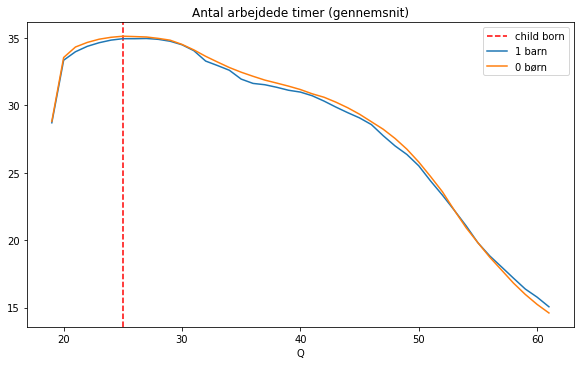

In [18]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.set_title("Antal arbejdede timer (gennemsnit)")
ax.axvline(x=25, label='child born', ls='--', color='red')

df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['action'].mean().plot(label='1 barn')
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['action'].mean().plot(label='0 børn')

ax.legend()

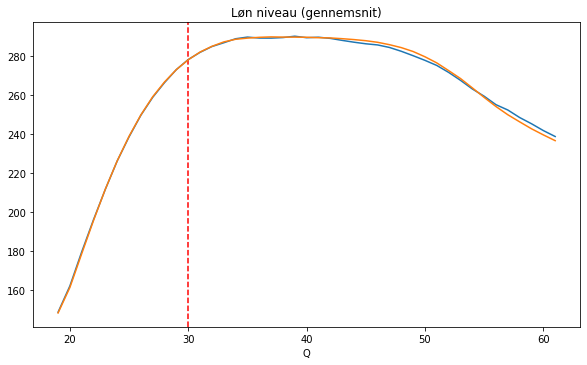

In [19]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.set_title("Løn niveau (gennemsnit)")
ax.axvline(x=30, label='child born', ls='--', color='red')

df_big.loc[df_results['episode'].isin(kids1)].groupby('Q')['S'].mean().plot(label='1 barn')
df_big.loc[df_results['episode'].isin(kids0)].groupby('Q')['S'].mean().plot(label='0 børn')

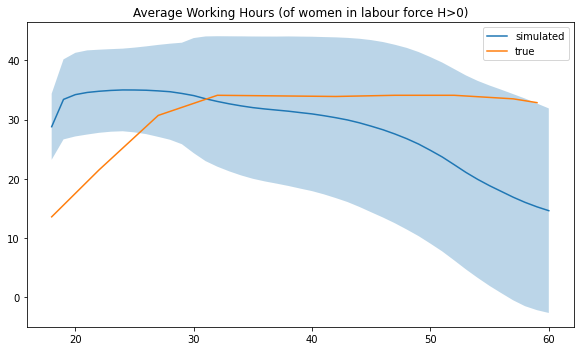

In [20]:
with open("..//data//women_hours_empirical", "rb") as f:
    women_hours_data = pickle.load(f)

f, ax = plt.subplots(1,1, figsize=FIGSIZE)
_x = range(18,60)
_xx = range(18, 61)
_mean = df_big.loc[df_results['action'] > 0].groupby('Q')['action'].mean()
_std = df_big.loc[df_results['action'] > 0].groupby('Q')['action'].std()
ax.plot(_xx, _mean, label='simulated')
ax.fill_between(_xx, _mean -_std, _mean + _std, alpha=0.3)
ax.plot(_x,women_hours_data[18:60], label = 'true')
ax.set_title("Average Working Hours (of women in labour force H>0)")
ax.legend()

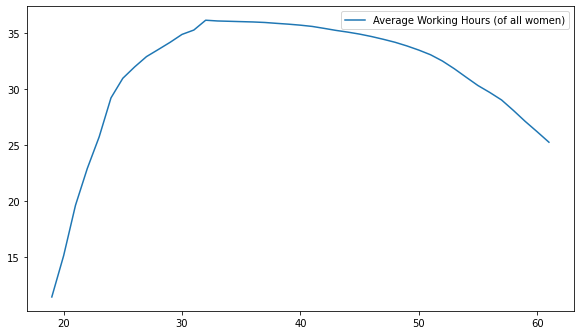

In [21]:
f, ax = plt.subplots(1,1,figsize=FIGSIZE)
plt.plot(df_results.groupby('Q')['action'].mean(), label = 'Average Working Hours (of all women)')
ax.legend()

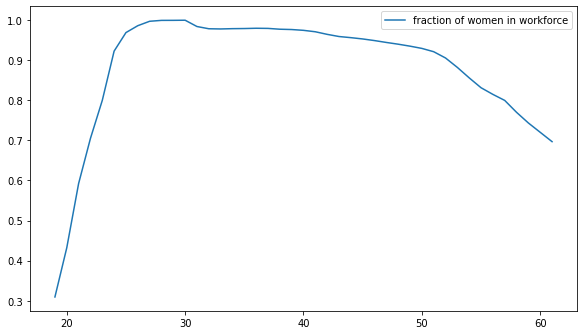

In [22]:

f, ax = plt.subplots(1,1, figsize=FIGSIZE)
ax.plot(df_results.loc[df_results['action'] > 0].groupby('Q')['action'].count() / max(df_results['episode']) ,label='fraction of women in workforce')
ax.legend()

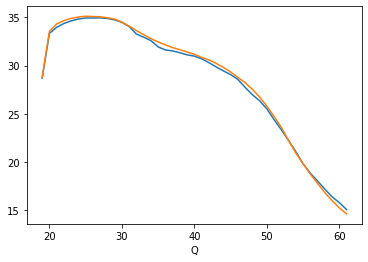

In [23]:
df_big.loc[df_big['episode'].isin(kids1)].groupby('Q')['action'].mean().plot(label='1 barn')
df_big.loc[df_big['episode'].isin(kids0)].groupby('Q')['action'].mean().plot(label='0 børn')